Metabolomics data was collected as a matrix represented by rows of experiment and columns of metabolite labels. 

We want to take this dataset and reduce its dimensionality as this is a multidimensional space that is difficult for scientists to interpret.

By reducing dimensionality (We use PCA, ICA, and UMAP) this may lead to visualizations or patterns in the data that is more salient to scientists rather than the complex matrix that is often saved in excel files or other conventional 2D conventions.  Therefore, we create this method which draws from an xlsx file, creates arrays, manipulates data, and then perform model analysis in separate boxes so that the code can be generally conformed for any sort of dataset (I.e., if using a dataset different from the original, data management and manipulation would require configuration, but the latter models will run on correctly configured data)

We focus here on a dataset from an xlsx file to extract metabolomics data across its experiments (Yielding a multidimensional array of experiments and measured metabolites of interest)

In [9]:
import pandas as pd
#import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import shapiro, anderson, norm


import umap as U

We first create a conversion factor as some values in the dataset are less than a certain threshold denoted by '<' value. We remove the 'less than' symbol and divide by the conversion factor to arbitrarilly reduce the number so that it is none 0 but relatively small compared to the threshold value

In [10]:
conversion_factor = 5 
# change this as the denominator to reduce threshold value divided by the conversion factor to arbitrarilly set. Without this modificiation the code will return NaN

There are multiple rows of time point data for each experiment all organized in rows, so first we must extract the names from the columns of interest and then extracting the specified single quanitity for each experiment (the metabolomics data is collected once per experiment)

We handle values with smaller than the threshold '<' by dividing by the 'conversion_factor' and we handle values larger than threshold by removing the larger than '>' symbol

In [11]:
df = pd.read_excel(r'C:\Users\uqkmuroi\Desktop\Van3_results.xlsx', header=0)

# Convert column letters to indices (AK to AU and BQ to DI)
columns_ak_au = df.iloc[:, 36:47].columns  # AK is the 37th column (index 36), AU is the 47th column (index 46)
columns_bq_di = df.iloc[:, 69:113].columns  # BQ is the 70th column (index 69), DI is the 113th column (index 112)

# Combine the headers
new_headers = list(columns_ak_au) + list(columns_bq_di)

# Create a new dataframe with the new headers
new_df = pd.DataFrame(columns=new_headers)

# Function to clean and convert the values
def clean_and_convert(value):
    #handle the case with '>'
    if isinstance(value, str) and value.startswith('>'):
        value=value[1:] #this removes the '>' symbol

    
    
    
    # Remove the '<' symbol if it exists and try converting to float
    if isinstance(value, str) and value.startswith('<'):
        try:
            # Remove '<', convert the value to float and divide by the conversion factor
            return float(value[1:]) / conversion_factor
        except ValueError:
            return np.nan  # If conversion fails, return NaN
    else:
        try:
            # Attempt to convert the value to a numeric value
            return float(value)
        except ValueError:
            return np.nan  # Return NaN if it's not convertible

# Group by 'UQ Strain'
grouped = df.groupby('UQ Strain')

# Fill the new dataframe with the information under the specified columns
for name, group in grouped:
    # Extract the relevant values for each group
    group_ak_au = group.iloc[:, 36:47].map(clean_and_convert)
    group_bq_di = group.iloc[:, 69:113].map(clean_and_convert)

    # Get the lone value for each group (only one value others are empty) we use max for now
    values_ak_au = group_ak_au.max(skipna=True)
    values_bq_di = group_bq_di.max(skipna=True)
    
    # Combine the values
    combined_values = pd.concat([values_ak_au, values_bq_di])
    
    # Append the combined values to the new dataframe
    new_df = pd.concat([new_df, combined_values.to_frame().T], ignore_index=True)

# Print the new dataframe
print(new_df)

    SAMe-3_POS : Conc. (uM)  HCy POS NonionP : Conc. (uM)  \
0                  0.000015                  4.120609e-07   
1                  0.000012                  1.819008e-07   
2                  0.000011                  4.031467e-06   
3                  0.000011                  1.142462e-06   
4                  0.000010                  4.057459e-06   
..                      ...                           ...   
59                 0.000008                  1.043654e-07   
60                 0.000010                  2.011783e-07   
61                 0.000009                  2.198107e-07   
62                 0.000009                  9.797275e-09   
63                 0.000006                  6.133752e-07   

    DAHP-10 NEG : Conc. (uM)  SAHe_NEG : Conc. (uM)  AMP NEG : Conc. (uM)  \
0                   0.000004           7.962529e-08              0.000002   
1                   0.000005           5.084183e-08              0.000002   
2                   0.000028        

C:\Users\uqkmuroi\AppData\Local\Temp\ipykernel_16884\1903270009.py:53: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



This checks to make sure all data below headers are quantitative.

In [86]:
# Check if there are any NaN values in the data (should list all metabolite labels and counts NaN, so it should all be 0 for dimensionality reduction to work)
nan_counts = new_df.isna().sum()
print(nan_counts)

SAMe-3_POS : Conc. (uM)             0
HCy POS NonionP : Conc. (uM)        0
DAHP-10 NEG : Conc. (uM)            0
SAHe_NEG : Conc. (uM)               0
AMP NEG : Conc. (uM)                0
NAD NEG : Conc. (uM)                0
ADP NEG NonionP : Conc. (uM)        0
KGA NEG NonionP : Conc. (uM)        0
NADH NEG : Conc. (uM)               0
PCA_NEG : Conc. (uM)                0
VAN_NEG : Conc. (uM)                0
23_G6P NEG IONP : Conc. (nM)        0
33_LAC NEG CCM : Conc. (nM)         0
20_F6P NEG CCM : Conc. (nM)         0
15_CMP NEG CCM : Conc. (nM)         0
53_UMP NEG IONP : Conc. (nM)        0
35_NAD NEG IONP : Conc. (nM)        0
28_GMP NEG CCM : Conc. (nM)         0
11_AMP NEG CCM : Conc. (nM)         0
48_SUCC NEG IONP : Conc. (nM)       0
32_KGA NEG CCM : Conc. (nM)         0
21_FUM NEG CCM : Conc. (nM)         0
6_6PG NEG IONP : Conc. (nM)         0
52_UDPNAG NEG IONP : Conc. (nM)     0
49_UDP NEG IONP : Conc. (nM)        0
25_GDP NEG CCM : Conc. (nM)         0
37_NADP NEG 

I added the below check from chatgpt, as I suspected the data was skewed, this can help visualize the skewness and show whether log transform can produce a normal distribution amenable to many ML models.

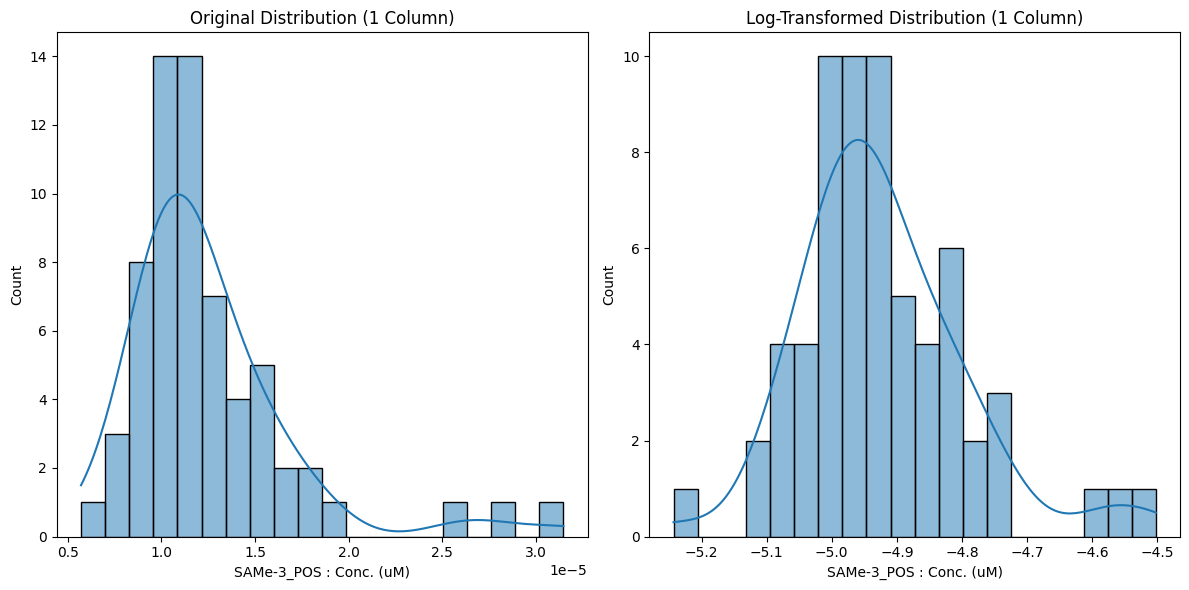

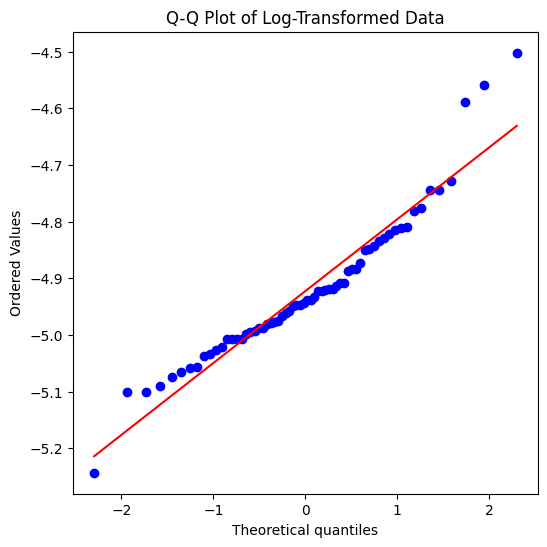

Shapiro-Wilk Test Statistic: 0.9385410596452504, p-value: 0.0032467922835960417
Anderson-Darling Test Statistic: 1.1151951874625752
Critical Values: [0.545 0.621 0.745 0.869 1.034]
Significance Level: [15.  10.   5.   2.5  1. ]


In [12]:
column_id = 0  #change this to pick the index column

# Apply log transformation to the dataset (we'll ignore non-positive values)
log_transformed_df = np.log10(new_df[new_df > 0])

# Plot histograms of the original data and log-transformed data
plt.figure(figsize=(12, 6))

# Plot the original data's first column (for example)
plt.subplot(1, 2, 1)
sns.histplot(new_df.iloc[:,column_id], kde=True, bins=20)
plt.title('Original Distribution ('+ str(column_id+1) +' Column)')

# Plot the log-transformed data
plt.subplot(1, 2, 2)
sns.histplot(log_transformed_df.iloc[:, column_id], kde=True, bins=20)
plt.title('Log-Transformed Distribution ('+ str(column_id+1) + ' Column)')

plt.tight_layout()
plt.show()

# Q-Q plot of the log-transformed data
import scipy.stats as stats
plt.figure(figsize=(6, 6))
stats.probplot(log_transformed_df.iloc[:, column_id], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')
plt.show()

# Perform Shapiro-Wilk test for normality on log-transformed data (e.g., first column)
stat, p_value = shapiro(log_transformed_df.iloc[:, column_id].dropna())  # drop NaN values if any
print(f'Shapiro-Wilk Test Statistic: {stat}, p-value: {p_value}')

# Perform Anderson-Darling test for normality
result = anderson(log_transformed_df.iloc[:, column_id].dropna(), dist='norm')
print(f'Anderson-Darling Test Statistic: {result.statistic}')
print(f'Critical Values: {result.critical_values}')
print(f'Significance Level: {result.significance_level}')

# If p-value of Shapiro-Wilk is high, or Anderson-Darling statistic is below the critical value,
# the log-transformed data may be considered normally distributed, suggesting log-normal distribution.


The above test on log distribution indicates that not all data is log-normal

Now that we've generated the Metabolomics headers and value for each of the experiment (64,55) in this example, it is obvious that the dimensions (number of columns) is quite large relative to the number of experiments, but first, an optional box is provided below to log 10 transform the dataset, considering they can span a large order of magnitude.

(Optional but recommended for metabolomics data (I did both as I didn't log tranform the data first))

For now we'll rewrite into new_df so that the rest of the code can remain unaltered but don't hit the next box if you don't want to log transform (or if your data contains negative values)

In [13]:
new_df = np.log10(new_df)

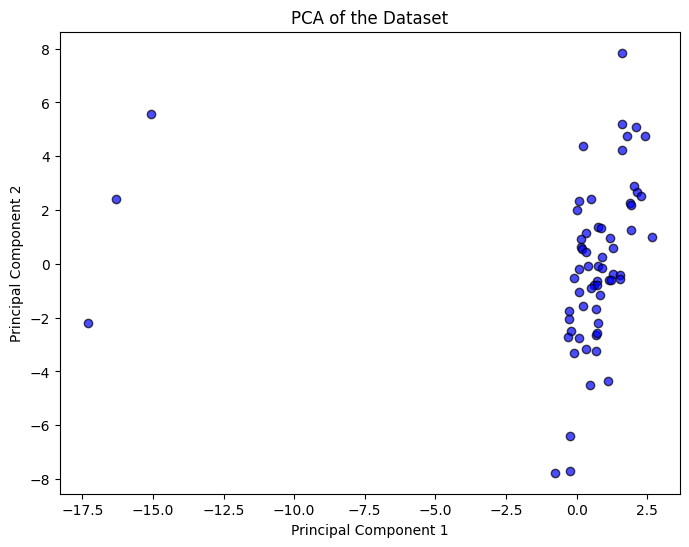

Explained variance ratio by PCA components: [0.24691773 0.16655858]


In [14]:
#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_df)

#apply PCA
pca = PCA (n_components =2) # you can change hyperparameter here.

pca_result = pca.fit_transform(scaled_data)


# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c='blue', edgecolor='k', alpha=0.7)
plt.title('PCA of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print the explained variance ratio to understand how much variance each component explains
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

Ok, so the code works to generate pc1 and pc2 graphed against eachother based purely on a given metabolomics dataset. Log transform changes the cluster and position of 3 outliers. (It also removes the negative trend relation between PC1 and PC2). Not sure what that means, but interpretability looks to be about the same (between log transformed and not)

But it only explains about .26+.18 = 44% of the variance in the data (with no log10 transform).
.25 and .17 =approx 42% of variance (with log10 transform)

Now we try to extend the methods with other dimensional reductions methods, as there are now many non-linear dimensional reductions techniques, as well as the necessity to disect information out of the analysis for scientific and publication purposes.

Color label the data points by strain to (for example) see where the outliers are from

In [7]:
# Plot the results

pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(pca_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
pca_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels

fig = px.scatter(pca_result_df, x='PC1', y='PC2', color='Experiment', title='PCA Results')
fig.show()

Let's get the loadings (influence of each variable) on the pca components

In [12]:
loadings = pca.components_.T #Transpose to match vraiables in rows (double check this to make sure it's correct)

#create a DataFrame for easier interpretation
loadings_df = pd.DataFrame(loadings,  index = new_df.columns, columns=['PC1', 'PC2'])

print(loadings_df)

                                       PC1       PC2
SAMe-3_POS : Conc. (uM)           0.024177  0.145350
HCy POS NonionP : Conc. (uM)     -0.020535 -0.001468
DAHP-10 NEG : Conc. (uM)         -0.009782  0.092407
SAHe_NEG : Conc. (uM)             0.131959  0.044318
AMP NEG : Conc. (uM)              0.035014 -0.009125
NAD NEG : Conc. (uM)              0.009868  0.067372
ADP NEG NonionP : Conc. (uM)      0.072845  0.277967
KGA NEG NonionP : Conc. (uM)      0.061560  0.094742
NADH NEG : Conc. (uM)             0.072083 -0.048158
PCA_NEG : Conc. (uM)              0.024099 -0.048957
VAN_NEG : Conc. (uM)              0.041315 -0.093136
23_G6P NEG IONP : Conc. (nM)     -0.113329  0.171440
33_LAC NEG CCM : Conc. (nM)       0.241814  0.044601
20_F6P NEG CCM : Conc. (nM)      -0.205249  0.105121
15_CMP NEG CCM : Conc. (nM)      -0.032744  0.066546
53_UMP NEG IONP : Conc. (nM)      0.205051  0.006124
35_NAD NEG IONP : Conc. (nM)      0.045853  0.143097
28_GMP NEG CCM : Conc. (nM)      -0.236918  0.

So that works and could be useful as a tool down the line

Now let's add PC3

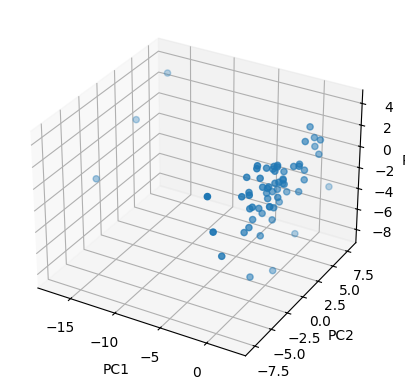

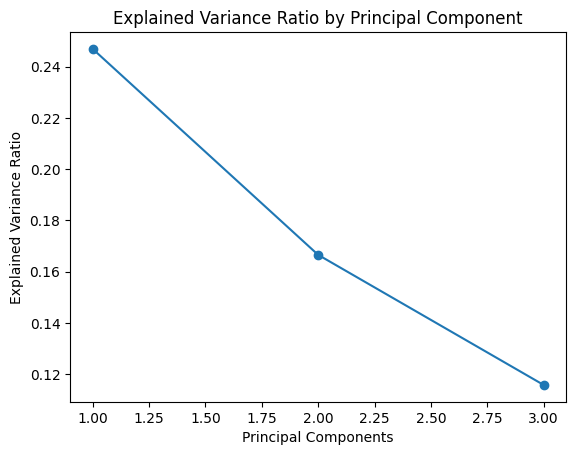

In [23]:
#apply PCA
pca = PCA (n_components =3) # you can change hyperparameter here.

pca_result = pca.fit_transform(scaled_data)

#pca_result = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()

above seems to explain over 50% (using 3 components), which is still not most of things (very similar whether we log transform)

Let's graph the explained variance ratio to see relative importance of these PCs (This will also work but with a warning, if you only use 2Pc instead of 3 (depending on how you run the codes before this section))

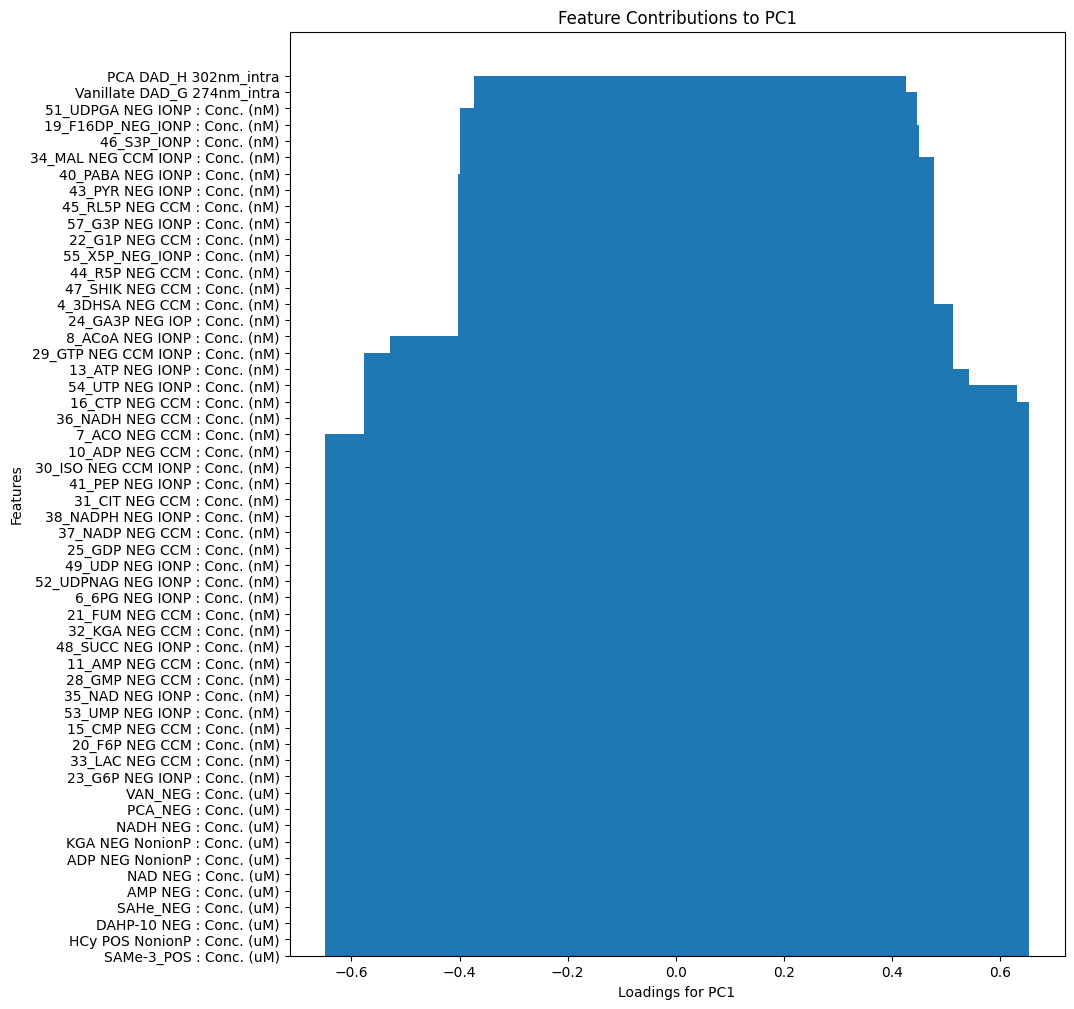

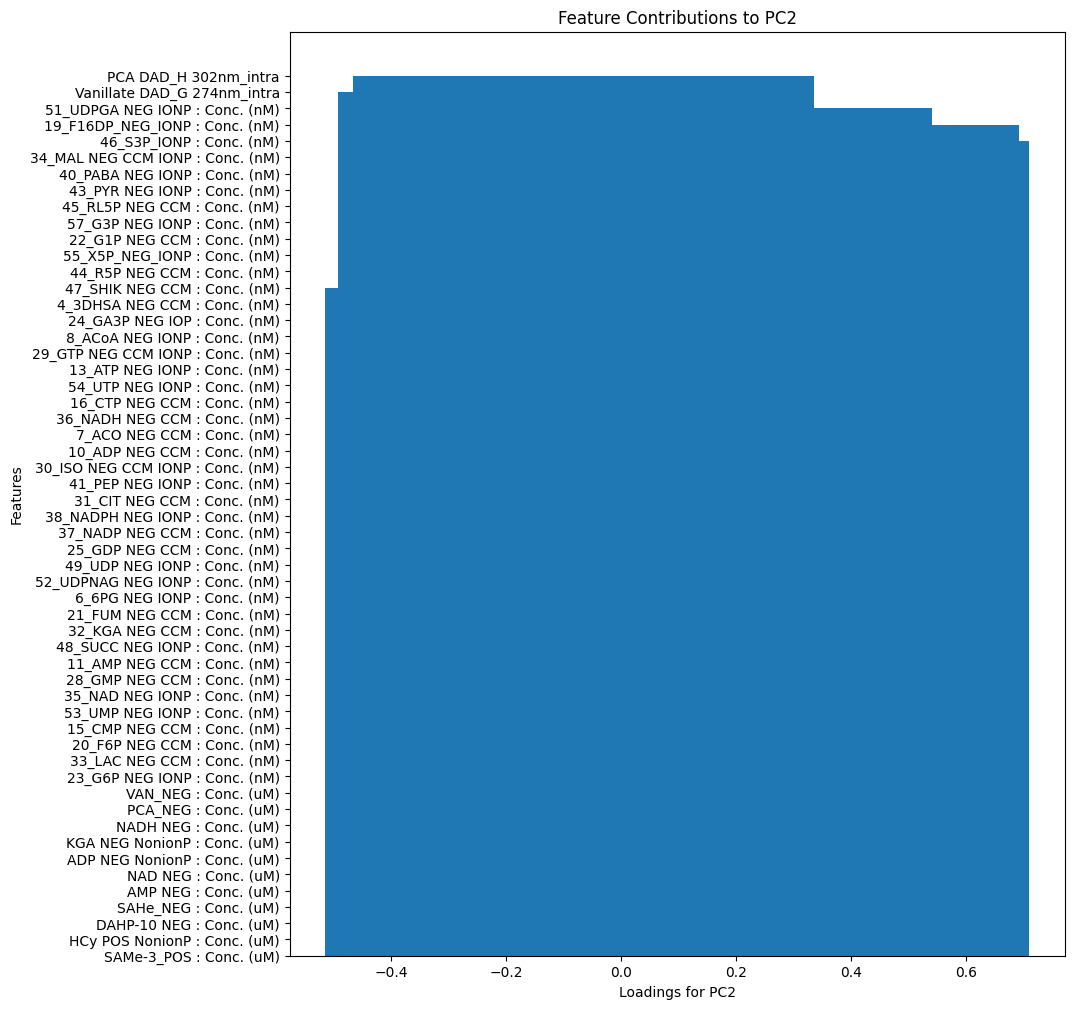

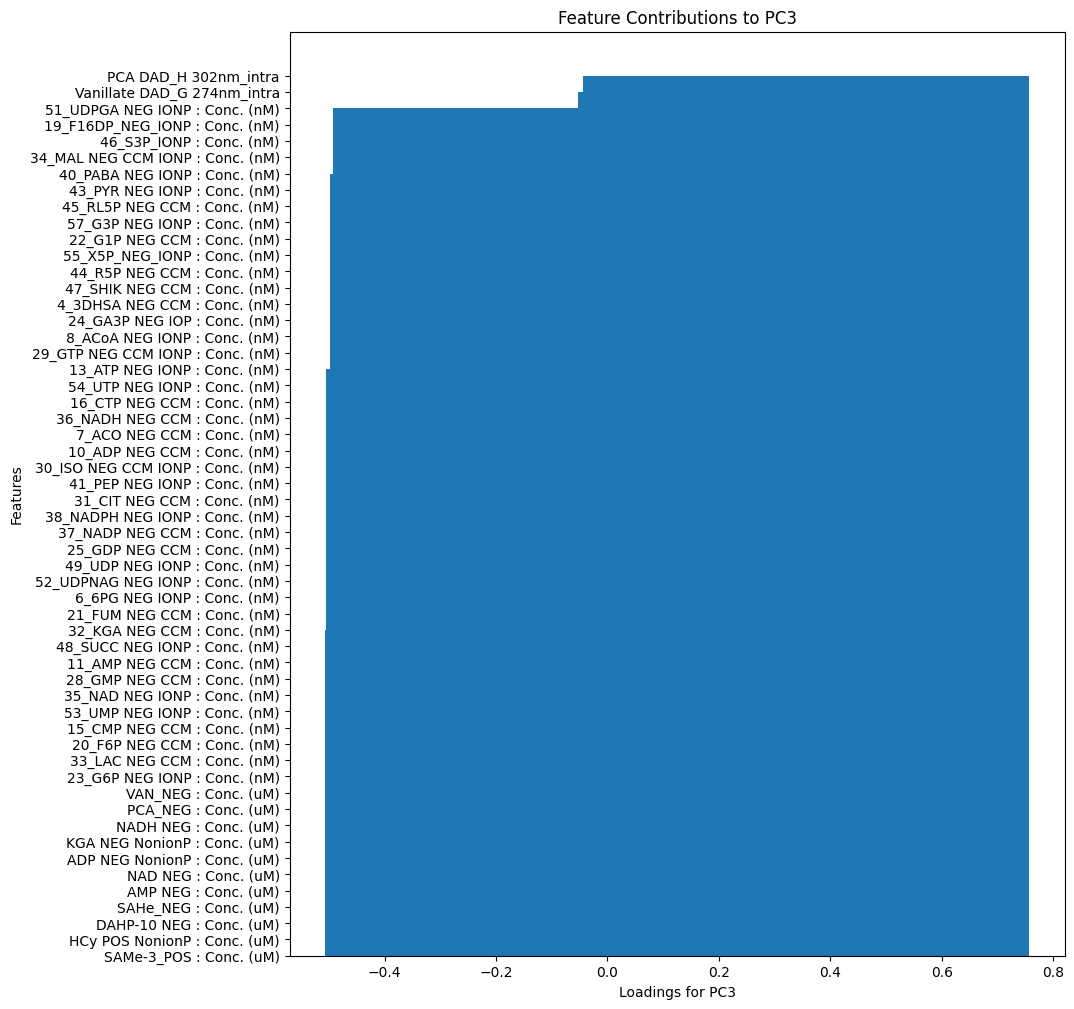

In [17]:
#loadings = pca.components_.T #Transpose to match vraiables in rows (double check this to make sure it's correct)

#create a DataFrame for easier interpretation
#loadings_df = pd.DataFrame(loadings,  index = new_df.columns, columns=['PC1', 'PC2'])


loadings = pca.components_  # Loadings matrix
loadings_df = pd.DataFrame(loadings, columns= new_df.columns, index=[f'PC{i+1}' for i in range(loadings.shape[0])])

# Visualizing the loadings for PC1 and PC2
plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[0], loadings_df.columns)
plt.xlabel('Loadings for PC1')
plt.ylabel('Features')
plt.title('Feature Contributions to PC1')
plt.show()

plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[1], loadings_df.columns)
plt.xlabel('Loadings for PC2')
plt.ylabel('Features')
plt.title('Feature Contributions to PC2')
plt.show()

plt.figure(figsize=(10, 12))
plt.bar(loadings_df.iloc[2], loadings_df.columns)
plt.xlabel('Loadings for PC3')
plt.ylabel('Features')
plt.title('Feature Contributions to PC3')
plt.show()

Not sure if above is correct... Might be easier to get someone to take a look at it.

Below let's focus on removing the outliers, first we analyze the z-score (plus since the above indicates there are 3 outliers, we find out what these values are)

In [29]:
from scipy.stats import zscore
z_score=np.abs(zscore(scaled_data))
np.set_printoptions(threshold=np.inf, precision =6, suppress=True)
print(z_score)

top_3_indices = np.argsort(z_score, axis=None)[-3:]

# Retrieve the top 3 values using the indices
top_3_values = z_score.flatten()[top_3_indices]

print("Top 3 Z-scores:", top_3_values)

[[0.782492 0.548135 0.345865 0.566318 0.096028 0.052553 0.919915 0.964767
  0.044839 0.173497 0.465563 0.130559 0.196033 0.042967 0.621565 0.039825
  0.0311   0.5037   0.139246 0.322588 0.468866 0.590439 1.366567 0.150953
  0.134105 0.635282 0.080569 0.338328 0.769563 0.19119  0.002009 0.016105
  0.184047 0.009093 0.313338 0.312731 0.424587 0.850706 1.145006 0.149796
  0.107979 0.507151 0.373973 0.063806 0.401884 0.610094 0.197082 2.033807
  0.311277 0.311541 0.86645  0.065408 0.45653  0.207252 0.14828 ]
 [0.105089 1.18266  0.171071 0.235528 0.227197 0.07916  1.201297 0.235063
  0.534675 0.359205 1.36576  1.030437 0.120047 0.214277 1.096188 0.001701
  0.056484 0.500077 0.260948 0.402762 0.387803 0.522063 0.706715 0.426009
  0.047902 0.708114 0.046563 0.258071 1.110789 0.095531 0.964292 0.020179
  0.404213 0.241986 0.63629  0.422478 0.399454 1.002014 1.096832 0.346671
  0.216907 0.998071 0.687855 0.578816 2.276285 0.030091 0.679118 0.061906
  0.276222 0.209509 1.379158 0.565744 0.726285

Below, since there are obvious outliers from the analysis, we remove the 3, using 4.5 based on the analysis from the cell above.

You can adjust threshold value if your data shows something different.

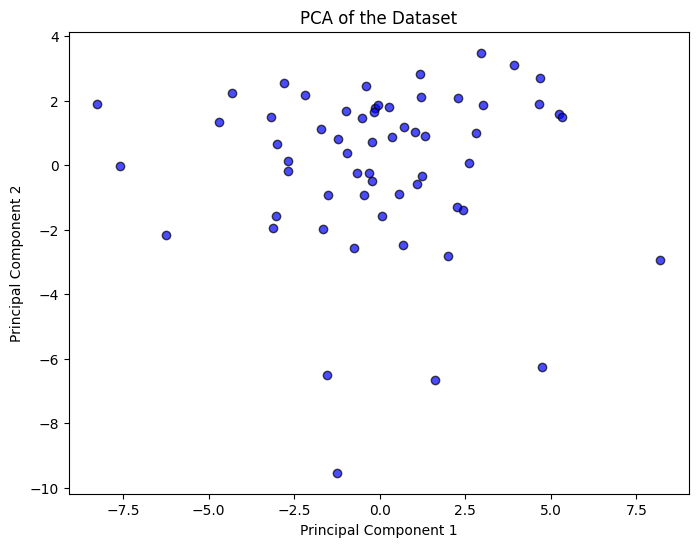

Explained variance ratio by PCA components: [0.20223143 0.13922155]


In [24]:
#Adjust how much outliers to remove
threshold_value = 4.5

#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_df)

from scipy.stats import zscore
z_scores = np.abs(zscore(scaled_data))  # Compute z-scores
data_no_outliers = scaled_data[(z_scores < threshold_value).all(axis=1)]  # Keep only rows with z-scores < threshold 


#apply PCA
pca = PCA (n_components =2) # you can change hyperparameter here.

pca_result = pca.fit_transform(data_no_outliers)


# Create a DataFrame with the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PCA1', 'PCA2'])

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PCA1'], pca_df['PCA2'], c='blue', edgecolor='k', alpha=0.7)
plt.title('PCA of the Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Print the explained variance ratio to understand how much variance each component explains
print(f"Explained variance ratio by PCA components: {pca.explained_variance_ratio_}")

In [ ]:
#### below is wrong, the experiment labels are not correct.

pca_result_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(pca_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
pca_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels


fig = px.scatter(pca_result_df, x='PC1', y='PC2', color='Experiment', title='PCA Results')
fig.show()

In [29]:
fig.write_html("PCA results.html")

So that's all cool, some visualisations of metabolomics data using pca


Let's explore ica now. We'll start with 'scaled_data' since this is a conveninent starting point for all dimensionality reduction and allows us to reuse the rest of the code (subsequent to it) with minimum fuss, as most of the work in these pipelines are in data management and data related decisions and organisation.

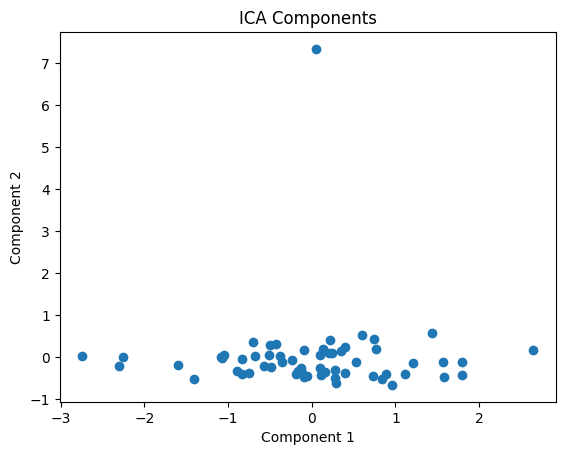

In [31]:
#scale the data
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(new_df)
scaled_data = scaler.fit_transform(data_no_outliers) #alternate version if you want to use no outliers (i had to change threshold value to 4 to show results below with better spread)


#apply ICA
ica = FastICA (n_components =2) # you can change hyperparameter here.
ica_result = ica.fit_transform(scaled_data)

#visualize the results
plt.scatter(ica_result[:,0], ica_result[:,1])#, c='blue', edgecolor='k', alpha=0.7)
plt.title('ICA Components')
plt.xlabel ('Component 1')
plt.ylabel ('Component 2')
plt.show()

I tried the above with log transformed and not log transformed and it shows similar results, thought the position of clusters change (however log transform seems to show a different spread pattern i nthe main cluster (with more opportunity to measure spread compared to not log transformed))

In [32]:
ica_result_df = pd.DataFrame(ica_result, columns=['C1', 'C2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(ica_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
ica_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels


fig = px.scatter(ica_result_df, x='C1', y='C2', color='Experiment', title='ica Results')
fig.show()

In [33]:
fig.write_html("ICA results.html")

In [ ]:
#this is gonna be a cheat, but I can't be bothered. We take the vanillate total max from each experiment from a separate file (already done) and use those instead of redoing with the current dataframe

df0 = pd.read_excel(r'C:\Users\uqkmuroi\Desktop\Gene or protein count data.xlsx')

idx = df.groupby('UQ Strain')['Vanillate DAD_G 274nm_tot'].idxmax()

df0=df0.loc[idx]
#print(df0)

label_van_tot = df0['Vanillate DAD_G 274nm_tot'].values


c:\Users\uqkmuroi\.virtualenvs\ML_for_precision_fermentation-7MdyzI83\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



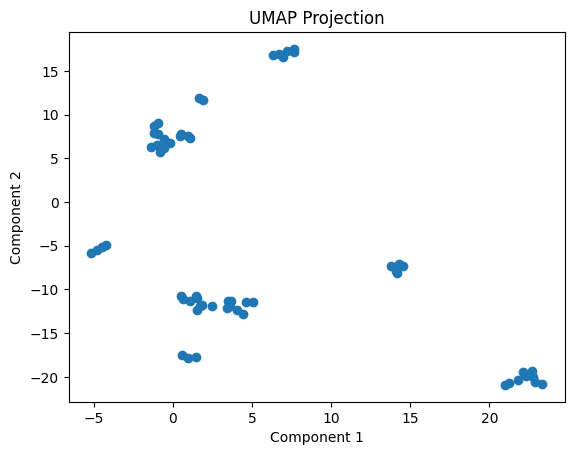

In [35]:
#scale the data
scaler = StandardScaler()
#scaled_data = scaler.fit_transform(new_df)
scaled_data = scaler.fit_transform(data_no_outliers) # alternate version with no outliers (turn this off and above on to keep the 3 outliers from the dataset)


# Apply UMAP
umap = U.UMAP(n_components=2, n_neighbors= 2, min_dist=0.5)  # Adjust n_components as needed (default is 2, 15, .1 I think)
umap_result = umap.fit_transform(scaled_data)  # Apply UMAP to your data

# Visualize the UMAP projection
plt.scatter(umap_result[:, 0], umap_result[:, 1])
plt.title('UMAP Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()


In [36]:
umap_result_df = pd.DataFrame(umap_result, columns=['C1', 'C2'])

unique_strains = df['UQ Strain'].unique()
num_rows= len(umap_result_df)
if len(unique_strains)< num_rows:
    unique_strains = unique_strains*(num_rows//len(unique_strains)) + unique_strains[:num_rows%len(unique_strains)]
umap_result_df['Experiment'] = unique_strains[:num_rows]  # Add experiment labels


fig = px.scatter(umap_result_df, x='C1', y='C2', color='Experiment', title='umap Results')
fig.show()

In [37]:
fig.write_html("UMAP results.html")

We were able to find the consistent outliers using pca, ica, and umap with non log tranformation and no outlier removal. They relate strains ref7, 078 and 359. 

Umap was able to get some interesting results using non-linear unsupervised learning to create clusters. But I'm still not sure how to interpret them.






I'm done up to the above.. it's pretty interesting, but hard to know what it will lead to, below are more experimental and new directions for analysis
Let's see if we can identify why they're outliers.

In [ ]:
'''
for feature in range(scaled_data_df.shape[1]):  # Loop through features
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=scaled_data_df[:, column])  # Plot a boxplot for the feature
    plt.title(f'Boxplot for Feature {feature}')
    plt.show()
'''

scaled_data_df = pd.DataFrame(scaled_data, columns=new_df.columns)


    # Loop through features to create boxplots and access column names
for feature in range(scaled_data_df.shape[1]):  # Loop through features
    # Access column name by index position (feature)
    feature_name = scaled_data_df.columns[feature]
    
    # Plot boxplot for the feature
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=scaled_data_df.iloc[:, feature])  # Use .iloc to access columns
    plt.title(f'Boxplot for Feature: {feature_name}')
    plt.xlabel(f'Feature: {feature_name}')
    plt.show()

    # Optionally, print the column name and its outlier points for deeper analysis
    outliers = scaled_data_df.iloc[:, feature][scaled_data_df.iloc[:, feature] > 3]  # For example, values > 3 are outliers (adjust threshold as needed)
    if len(outliers) > 0:
        print(f'Outliers in {feature_name}:')
        print(outliers)


In [ ]:
print(scaled_data)
print(scaled_data_df)

In this section we want to apply pls-da, start by running the earliest section of the model to ensure that new_df is the log transformed dataframe of metabolomics values ( I also tested without log transforming, which seems to work as well (sometimes works better actually for correctly predicting high (above target_data_threshold)))

In [79]:
target_data_threshold = 2500 # this is the separator between high and low of target metabolite


#scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_df)

#since we've already grouped by UQ Straing, we just want the maximum from each group for Van total
target_data = grouped['Vanillate DAD_G 274nm_tot'].max()
print(target_data)

# it seems the discriminant analysis only works on classificiation data so let's split the van totals into high and low
y_binned = np.where(target_data > target_data_threshold, 1, 0) # 1 for high (values over 3000) and 0 for low.

print (y_binned)


UQ Strain
VAN_011     4952.447068
VAN_022     1164.833526
VAN_024     2909.079446
VAN_034     3843.687074
VAN_035     4110.693695
               ...     
VAN_391     6482.053633
VAN_392     3669.222194
VAN_393     3693.414898
VAN_396     2958.085578
VAN_REF7    3192.759655
Name: Vanillate DAD_G 274nm_tot, Length: 64, dtype: float64
[1 0 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 1]


Now we try to fit this to the model pls-da

In [80]:
pls= PLSRegression(n_components=2) # can change latent variable here

# apply pls regression
X_pls, y_pls = pls.fit_transform(scaled_data, y_binned)

# apply discriminant analysis (da) on the PLS components
lda = LinearDiscriminantAnalysis()
lda.fit(X_pls, y_binned)

# Now we want to show y_pred from lda
y_pred = lda.predict(X_pls)

#Evaluation
print("Classification Report:")
print(classification_report(y_binned, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_binned, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.81      0.80        32
           1       0.81      0.78      0.79        32

    accuracy                           0.80        64
   macro avg       0.80      0.80      0.80        64
weighted avg       0.80      0.80      0.80        64

Confusion Matrix:
[[26  6]
 [ 7 25]]


Let's make a VIP score from this to determine the influential variables

Shape of X_scaled: (64, 55)
Shape of T (PLS scores): (64, 2)
Shape of W (PLS weights): (55, 2)
Shape of SS (sum of squares): (2,)
Normalized SS: [0.64905381 0.35094619]
Shape of VIP scores: (2,)
VIP scores shape is correct!


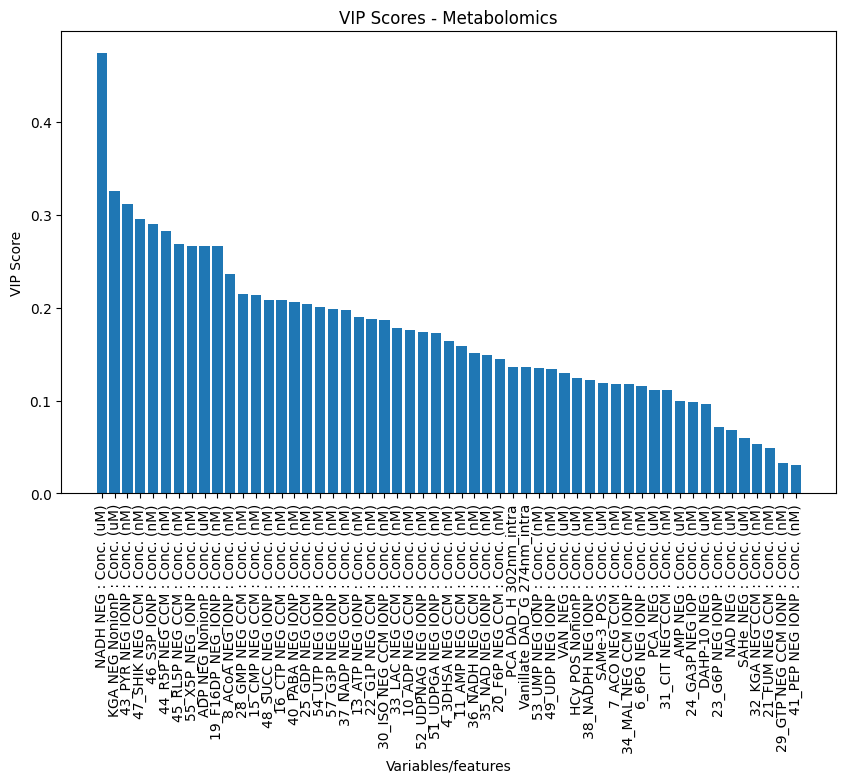

In [81]:
# Shape check: Ensure X_scaled is 2D (n_samples, n_features)
print(f"Shape of X_scaled: {scaled_data.shape}")


# Get the PLS components
T = pls.x_scores_  # PLS scores (latent variables)
W = pls.x_weights_  # PLS weights

# Shape check: Ensure T and W are 2D arrays
print(f"Shape of T (PLS scores): {T.shape}")
print(f"Shape of W (PLS weights): {W.shape}")

# Calculate the sum of squares for each component
SS = np.sum(T**2, axis=0)  # Sum of squares of the scores
print(f"Shape of SS (sum of squares): {SS.shape}")

# Normalize the sum of squares (if required)
SS = SS / np.sum(SS)  # Normalize to sum to 1
print(f"Normalized SS: {SS}")

# Compute the VIP scores
# VIP scores formula: sqrt(p * sum(W^2) * SS)
vip_scores = np.sqrt(scaled_data.shape[1] * np.sum(W**2, axis=0) * SS)
print(f"Shape of VIP scores: {vip_scores.shape}")

# correct the shape by summing over the compnents (axis=1) and multiply weights sqaured by normalized SS
vip_scores = np.sqrt(np.sum(W**2, axis=1) *np.sum(SS))

# Ensure VIP scores have the same length as the number of features
if vip_scores.shape[0] == scaled_data.shape[1]:
    print("VIP scores shape is correct!")
else:
    print("Error: VIP scores shape mismatch!")

scaled_data_labels = new_df.columns
# Sort the VIP scores in descending order and reorder the feature names accordingly
sorted_indices = np.argsort(vip_scores)[::-1]  # Indices of sorted VIP scores in descending order
sorted_vip_scores = vip_scores[sorted_indices]
sorted_feature_names = [scaled_data_labels[i] for i in sorted_indices]

# Plot VIP scores
plt.figure(figsize=(10, 6))
plt.bar(range(scaled_data.shape[1]), sorted_vip_scores)
plt.xticks(range(scaled_data.shape[1]), sorted_feature_names, rotation=90)
plt.title('VIP Scores - Metabolomics')
plt.xlabel('Variables/features')
plt.ylabel('VIP Score')
plt.show()
